Début ZFE Grenoble : 2019-05-02
Stations donneuses :


,station_id,station_name,station_env,station_influence
0,FR15018,Voiron Urbain,Urbaine,Fond
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond
5,FR33102,CHAMBERY LE HAUT,Urbaine,Fond
6,FR33111,SAINT JEAN,Urbaine,Fond
7,FR33203,ANNECY Rocade,Urbaine,Trafic
8,FR36002,Valence Urb. Centre,Urbaine,Fond
9,FR36019,Romans-sur-Isère,Urbaine,Fond


Aperçu du panel mensuel donneurs :


,station_id,station_name,date,no2_ug_m3
0,FR15018,Voiron Urbain,2016-02-01,22.724000
1,FR15018,Voiron Urbain,2016-03-01,22.838710
2,FR15018,Voiron Urbain,2016-04-01,13.550000
3,FR15018,Voiron Urbain,2016-05-01,10.122581
4,FR15018,Voiron Urbain,2016-06-01,8.570000


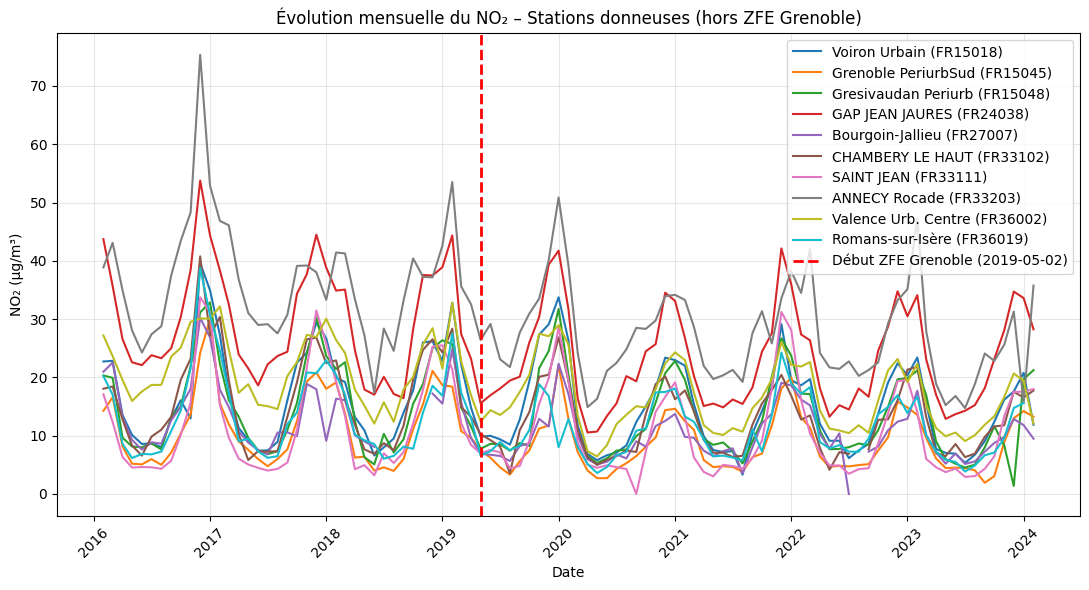

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# ---------- 1) date de début de la ZFE Grenoble ----------
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
print("Début ZFE Grenoble :", zfe_start.date())

# ---------- 2) stations donneuses (hors ZFE Grenoble) ----------
stations_meta = pd.read_csv(DATA / "no2_stations_meta.csv")

# on considère comme donneurs toutes les stations avec in_zfe_grenoble == False
donors = stations_meta[stations_meta["in_zfe_grenoble"] == False].copy()
print("Stations donneuses :")
display(donors[["station_id", "station_name", "station_env", "station_influence"]])

# ---------- 3) NO2 daily propre pour toutes les stations ----------
no2 = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
no2["date"] = pd.to_datetime(no2["date"])

# garder uniquement les donneurs
no2_donors = no2[no2["station_id"].isin(donors["station_id"])].copy()

# ---------- 4) agrégation mensuelle par station donneuse ----------
monthly = (
    no2_donors
    .set_index("date")
    .groupby(["station_id", "station_name"])["no2_ug_m3"]
    .resample("MS")   # MS = début de mois
    .mean()
    .reset_index()
)

print("Aperçu du panel mensuel donneurs :")
display(monthly.head())

# ---------- 5) tracé multi-séries ----------
plt.figure(figsize=(11, 6))

for (sid, name), sub in monthly.groupby(["station_id", "station_name"]):
    plt.plot(sub["date"], sub["no2_ug_m3"], label=f"{name} ({sid})")

# trait vertical rouge = début ZFE Grenoble
plt.axvline(
    zfe_start,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Début ZFE Grenoble ({zfe_start.date()})",
)

plt.title("Évolution mensuelle du NO₂ – Stations donneuses (hors ZFE Grenoble)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
